In [1]:
## Imports
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import gc
import pickle

In [2]:
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)  # MURA images are grayscale
    image = tf.image.resize(image, [224, 224])      # Match ResNet/VGG input shape
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [3]:
with open('mura_train.pkl', 'rb') as f:
    train_images, train_labels = pickle.load(f)

with open('mura_val.pkl', 'rb') as f:
    val_images, val_labels = pickle.load(f)

# Rebuild datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(preprocess_image).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)


In [4]:
# Clear previous session
tf.keras.backend.clear_session()
gc.collect()

# Build custom CNN
inputs = Input(shape=(224, 224, 1))

x = Conv2D(32, (3, 3), padding='same', activation='relu',
           kernel_initializer='glorot_uniform')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu',
           kernel_initializer='glorot_uniform')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu',
           kernel_initializer='glorot_uniform')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu',
           kernel_initializer='glorot_uniform')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu',
           kernel_initializer='glorot_uniform')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=inputs, outputs=outputs)


In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,830,369 (98.54 MB)

 Trainable params: 25,829,921 (98.53 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)


Epoch 1/20


1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3453s 3s/step - accuracy: 0.7941 - loss: 0.8251 - val_accuracy: 0.5130 - val_loss: 5.1035
Epoch 2/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5466s 5s/step - accuracy: 0.7168 - loss: 0.6671 - val_accuracy: 0.5334 - val_loss: 3.8857
Epoch 3/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5298s 5s/step - accuracy: 0.7018 - loss: 0.6267 - val_accuracy: 0.5221 - val_loss: 3.4023
Epoch 4/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5306s 5s/step - accuracy: 0.6596 - loss: 0.6450 - val_accuracy: 0.5168 - val_loss: 2.2884
Epoch 5/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5434s 5s/step - accuracy: 0.7045 - loss: 0.6247 - val_accuracy: 0.5258 - val_loss: 1.8914
Epoch 6/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5667s 5s/step - accuracy: 0.7187 - loss: 0.6210 - val_accuracy: 0.5218 - val_loss: 1.5510
Epoch 7/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5842s 5s/step - accuracy: 0.7044 - loss: 0.6160 - val_accuracy: 0.5221 - val_loss: 2.6697
Epoch 8/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5617s 5s/step - accuracy: 0.7374 - loss: 0.59

In [12]:
model.save("models/mura_transfer_cnn_finetune.keras")  # Saves as a directory

100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 923ms/step - accuracy: 0.4595 - loss: 1.8514
Validation accuracy: 0.5217663645744324


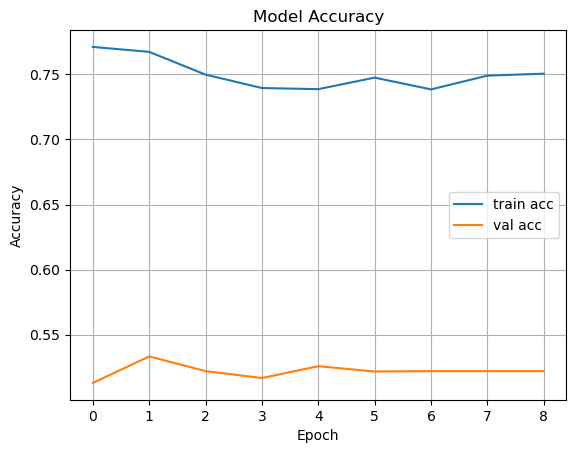

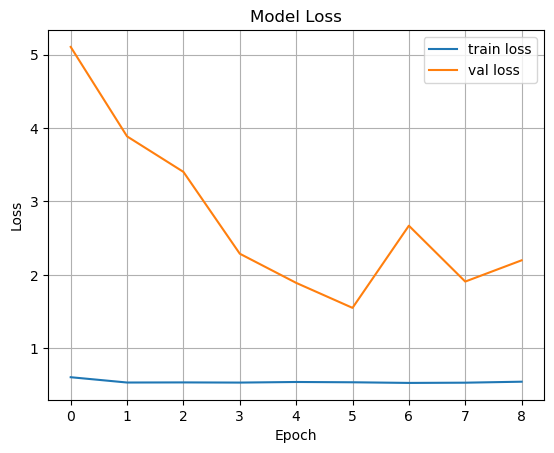

In [7]:
# Evaluate
test_loss, test_acc = model.evaluate(val_ds)
print("Validation accuracy:", test_acc)

# Accuracy plot
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━

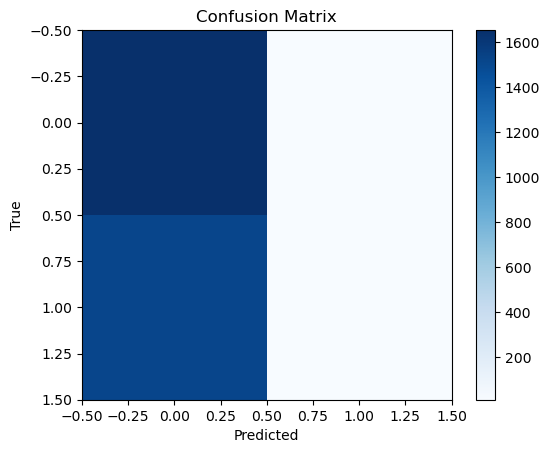

In [8]:
# Predict
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()
